In [14]:
#!pip install jax
#!pip install -U "jax[cpu]"
#!pip install mat73
#!pip install scikit-learn-extra 
# Comment out the lines above after running them once. 
#!pip install pandas
#!pip install seaborn

# Importing the libraries
import sys
import psutil
import time
import matplotlib.pyplot as plt

import numpy as np
import jax.numpy as jnp

from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import scipy
from scipy import signal
from scipy.signal import find_peaks
import json
import mat73
import math
import os
import pandas as pd
import seaborn as sns


In [15]:
def compare_sources(list1, list2, tolerance):
    #tolerance = 5
    duplicate_matches = 0

    list1_matches = set()
    list2_matches = set()
    list1_duplicates = set()
    list2_duplicates = set()

    for  spike_idx in list1:
        for spike2_idx in list2:
            #print(f'Cheking: {spike_idx} & {spike2_idx}')
            #print(f'Difference: {abs(spike_idx-spike2_idx)}')

            if  abs(spike_idx-spike2_idx) < tolerance:  
                if spike_idx not in list1_matches and spike2_idx not in list2_matches:
                    
                    # Add the spike pair to the matched spikes
                    list1_matches.add(spike_idx)
                    list2_matches.add(spike2_idx)

                else:
                    # Add the spike pair to the duplicate list
                    list1_duplicates.add(spike_idx)
                    list2_duplicates.add(spike2_idx)

                    # Incriment the duplicate counter
                    duplicate_matches += 1


            if (spike_idx - spike2_idx) < - tolerance:
                #print('There is no way back!')
                break

    list1_duplicates = list1_duplicates - list1_matches
    list2_duplicates = list2_duplicates - list2_matches

    matched_count = len(list1_matches) + len(list2_matches)
    spikes_with_duplicates = len(set(list1_duplicates)) + len(set(list2_duplicates))
    unmatched_count = len(list1) + len(list2) - matched_count - len(list1_duplicates) - len(list2_duplicates)
    rate_of_agreement = (matched_count / (matched_count + unmatched_count + spikes_with_duplicates)) * 100
    print("Start")
    print(matched_count)
    print(unmatched_count)
    print(spikes_with_duplicates)
    print(len(list1))
    print(len(list2))
    print(rate_of_agreement)
    print("\n")

    return matched_count, spikes_with_duplicates, unmatched_count, rate_of_agreement

In [20]:
# Fetch the true sources
file_path = '../data/SIMULATION_56_40.mat'
# Create a dictionary from the matlab data file.
data_dict = scipy.io.loadmat(file_path)

# Extract the EMG spike data into a numpy array
MUPulses = np.array(data_dict['MUPulses'][0])
print(MUPulses.shape)
print(MUPulses[40].shape)

(56,)
(1, 719)


In [23]:
roa_tolerance = np.round(1 * 0.008 / (1/4096))
MUPulsesA = MUPulses

# Opening JSON file
f = open('../data/output2.json')
# returns JSON object as 
# a dictionary
MUPulsesB = json.load(f)
 # Closing file
f.close()

roa_matrix = pd.DataFrame(0, index=range(len(MUPulsesA)), columns=range(len(MUPulsesB)))
dup_matrix = pd.DataFrame(0, index=range(len(MUPulsesA)), columns=range(len(MUPulsesB)))

spikeCountTrue = []
spikeCountCalc = []

print(roa_matrix.shape)
loopidx = 0
# Looping through the sources A and sources B and computing their mutual rate of agreement.
for idxA, sourceA in enumerate(MUPulsesA):
    sourceA = sourceA[0] # This line is required for the ground truth sources, as they have a slightly different format.
    spikeCountTrue.append(len(sourceA))
    for idxB, sourceB in enumerate(MUPulsesB):
        sourceB = sourceB["SpikeTrain"]
        if loopidx <1:
            spikeCountCalc.append(len(sourceB))

        matched_count, spikes_with_duplicates, unmatched_count, rate_of_agreement = compare_sources(sourceA, sourceB, roa_tolerance)

        roa_matrix.iloc[idxA, idxB] = np.round(rate_of_agreement).astype(int)
        dup_matrix.iloc[idxA, idxB] = spikes_with_duplicates

    loopidx = 1

print(roa_matrix)
print(dup_matrix)

(56, 15)
Start
536
980
0
760
756
35.35620052770449


Start
630
866
0
760
736
42.112299465240646


Start
614
864
0
760
718
41.5426251691475


Start
562
917
0
760
719
37.99864773495605


Start
564
883
0
760
687
38.977194194885975


Start
606
889
0
760
735
40.53511705685619


Start
592
885
0
760
717
40.081245768449556


Start
532
941
0
760
713
36.11676849966056


Start
554
913
0
760
707
37.76414451261077


Start
616
850
0
760
706
42.01909959072306


Start
586
902
0
760
728
39.38172043010753


Start
580
872
0
760
692
39.94490358126722


Start
608
897
0
760
745
40.39867109634552


Start
570
906
0
760
716
38.61788617886179


Start
710
791
0
760
741
47.30179880079947


Start
594
919
0
757
756
39.25974884335757


Start
558
935
0
757
736
37.374413931681175


Start
596
879
0
757
718
40.40677966101695


Start
540
936
0
757
719
36.58536585365854


Start
548
896
0
757
687
37.95013850415512


Start
540
952
0
757
735
36.193029490616624


Start
566
908
0
757
717
38.398914518317504


Start
648
822
0
75

In [59]:
def create_binary_list(indices, total_length):
    """
    Create a binary list where indices are marked as 1s.
    """
    binary_list = [0] * (total_length+1)
    for index in indices:
        binary_list[index] = 1
    return binary_list

def calculate_rate_of_agreement(list1, list2):
    """
    Calculate the rate of agreement between two lists of spike indices.
    """
    total_indices = len(list1)+len(list2)
    max_length = max(list1[-1], list2[-1])
    max_agreement = 0
    best_shift = 0
       # Create binary lists for list1 and list2
    binary_list1 = create_binary_list(list1, max_length)
    binary_list2 = create_binary_list(list2, max_length)

    print(len(binary_list1))
    print(len(binary_list2))

    # Iterate through possible shifts
    for shift in range(-10, 11):
        agreement_count = 0

        # Shift binary_list1 by shift amount
        shifted_binary_list1 = [0] * max_length
        if shift < 0:
            shifted_binary_list1[-shift:] = binary_list1[:shift]
        elif shift > 0:
            shifted_binary_list1[:-shift] = binary_list1[shift:]


 
        # Perform element-wise multiplication and sum
        for i in range(max_length):
            agreement_count += shifted_binary_list1[i] * binary_list2[i]

        # Calculate rate of agreement for current shift
        rate_of_agreement = (agreement_count * 2 / total_indices) * 100

        # Update max agreement and best shift if current shift has higher rate of agreement
        if rate_of_agreement > max_agreement:
            max_agreement = rate_of_agreement
            best_shift = shift

    return best_shift, max_agreement

# Example usage
list1 = [1, 3, 5, 7, 9]
list2 = [2, 4, 6, 8, 10]
shift, rate_of_agreement = calculate_rate_of_agreement(list1, list2)
print("Best shift:", shift)
print("Rate of agreement:", rate_of_agreement)

11
11
Best shift: -1
Rate of agreement: 80.0


In [60]:
roa_tolerance = np.round(1 * 0.008 / (1/4096))
MUPulsesA = MUPulses

# Opening JSON file
f = open('../data/output2.json')
# returns JSON object as 
# a dictionary
MUPulsesB = json.load(f)
 # Closing file
f.close()

roa_matrix = pd.DataFrame(0, index=range(len(MUPulsesA)), columns=range(len(MUPulsesB)))
dup_matrix = pd.DataFrame(0, index=range(len(MUPulsesA)), columns=range(len(MUPulsesB)))

spikeCountTrue = []
spikeCountCalc = []

print(roa_matrix.shape)
loopidx = 0
# Looping through the sources A and sources B and computing their mutual rate of agreement.
for idxA, sourceA in enumerate(MUPulsesA):
    sourceA = sourceA[0] # This line is required for the ground truth sources, as they have a slightly different format.
    spikeCountTrue.append(len(sourceA))
    for idxB, sourceB in enumerate(MUPulsesB):
        sourceB = sourceB["SpikeTrain"]
        if loopidx <1:
            spikeCountCalc.append(len(sourceB))

        print(len(sourceA))
        print(len(sourceB))

        shift, rate_of_agreement = calculate_rate_of_agreement(sourceA, sourceB)


        roa_matrix.iloc[idxA, idxB] = rate_of_agreement 


    loopidx = 1

print(roa_matrix)


(56, 15)
760
756
122919
122919
760
736
122919
122919
760
718
122919
122919


/tmp/ipykernel_60653/629190779.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9234828496042217' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement
/tmp/ipykernel_60653/629190779.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.2032085561497325' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement
/tmp/ipykernel_60653/629190779.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9472259810554804' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement


760
719
122919
122919
760
687
122919
122919
760
735
122919
122919


/tmp/ipykernel_60653/629190779.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9465855307640297' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement
/tmp/ipykernel_60653/629190779.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.10573600552868' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement
/tmp/ipykernel_60653/629190779.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0702341137123745' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement


760
717
122919
122919
760
713
122919
122919
760
707
122919
122919


/tmp/ipykernel_60653/629190779.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0832769126607988' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement
/tmp/ipykernel_60653/629190779.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.2219959266802443' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement
/tmp/ipykernel_60653/629190779.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0906612133606' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement


760
706
122919
122919
760
728
122919
122919
760
692
122919
122919


/tmp/ipykernel_60653/629190779.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0914051841746248' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement
/tmp/ipykernel_60653/629190779.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.3440860215053763' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement
/tmp/ipykernel_60653/629190779.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.1019283746556474' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement


760
745
122919
122919
760
716
122919
122919
760
741
122919
122919


/tmp/ipykernel_60653/629190779.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.5946843853820596' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement
/tmp/ipykernel_60653/629190779.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9485094850948509' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement
/tmp/ipykernel_60653/629190779.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.5989340439706863' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement


757
756
122825
122825
757
736
122865
122865
757
718
122825
122825
757
719
122839
122839
757
687
122825
122825
757
735
122825
122825
757
717
122869
122869
757
713
122844
122844
757
707
122825
122825
757
706
122825
122825
757
728
122837
122837
757
692
122825
122825
757
745
122825
122825
757
716
122825
122825
757
741
122825
122825
765
756
122962
122962
765
736
122962
122962
765
718
122962
122962
765
719
122962
122962
765
687
122962
122962
765
735
122962
122962
765
717
122962
122962
765
713
122962
122962
765
707
122962
122962
765
706
122962
122962
765
728
122962
122962
765
692
122962
122962
765
745
122962
122962
765
716
122962
122962
765
741
122962
122962
763
756
122878
122878
763
736
122878
122878
763
718
122878
122878
763
719
122878
122878
763
687
122878
122878
763
735
122878
122878
763
717
122878
122878
763
713
122878
122878
763
707
122878
122878
763
706
122878
122878
763
728
122878
122878
763
692
122878
122878
763
745
122878
122878
763
716
122878
122878
763
741
122878
122878
764
756
12

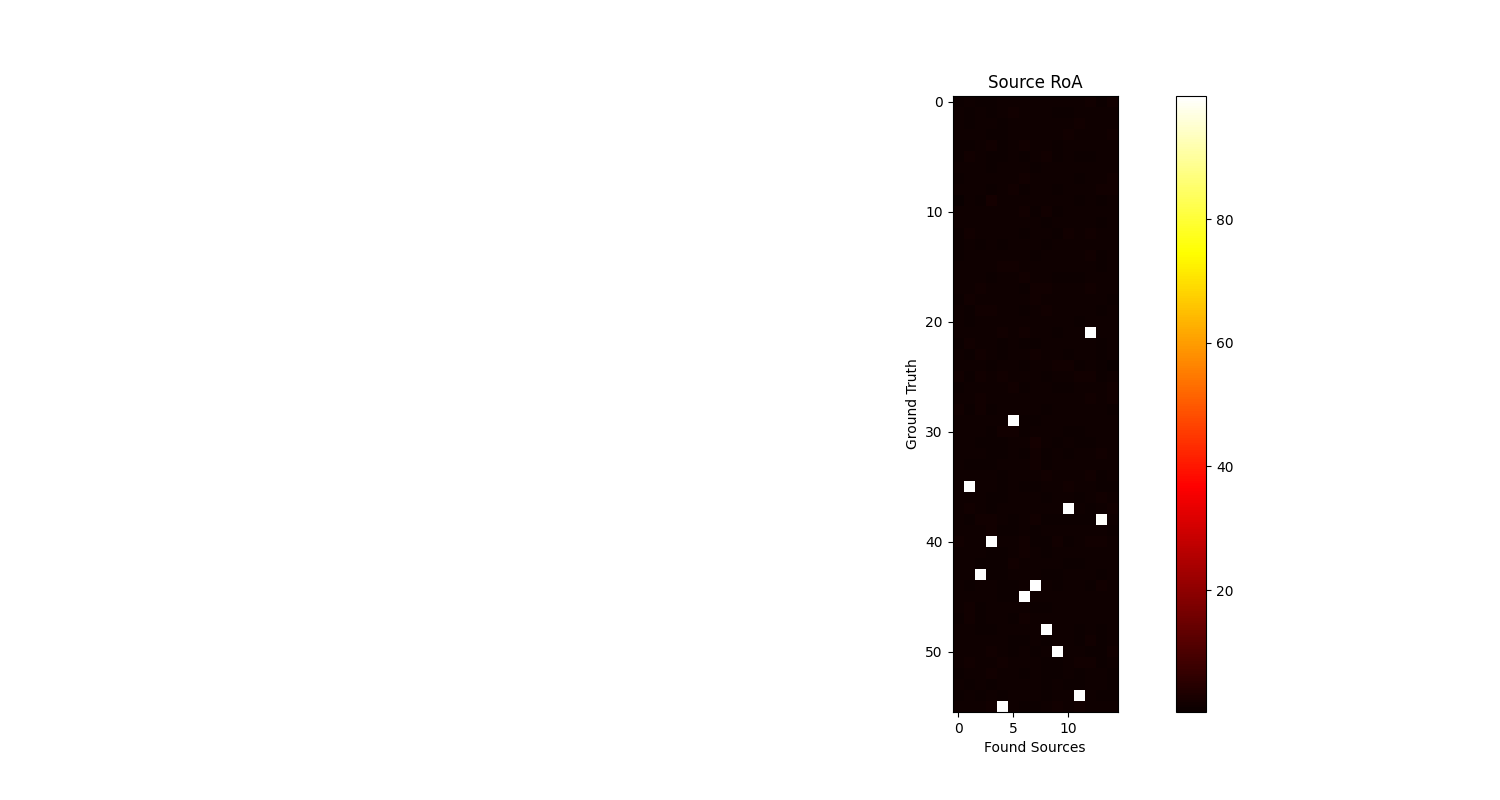

In [61]:
# Step 3: Plot the Heatmap
plt.figure(figsize=(15, 8))
plt.imshow(roa_matrix, cmap='hot', interpolation='nearest')

# Step 4: Customize the Plot (Optional)
plt.colorbar()  # Add color bar
plt.xlabel('Found Sources')
plt.ylabel('Ground Truth')
plt.title('Source RoA')

# Step 5: Show or Save the Plot
plt.show()

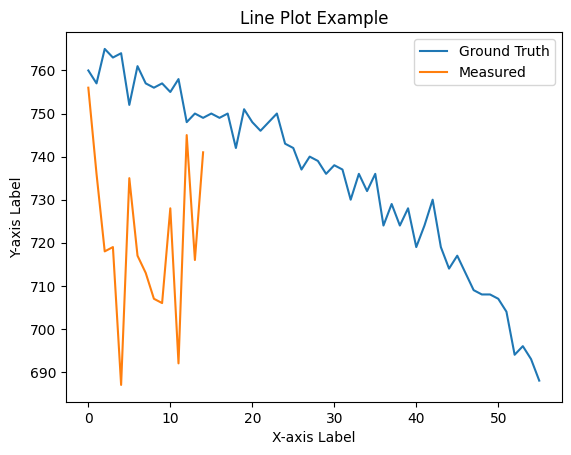

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns


# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the first line
sns.lineplot(spikeCountTrue, label='Ground Truth', ax=ax)

# Plot the second line
sns.lineplot(spikeCountCalc, label='Measured', ax=ax)

# Add labels and title
ax.set_xlabel('X-axis Label')
ax.set_ylabel('Y-axis Label')
ax.set_title('Line Plot Example')

# Show the legend
ax.legend()

# Display the plot
plt.show()

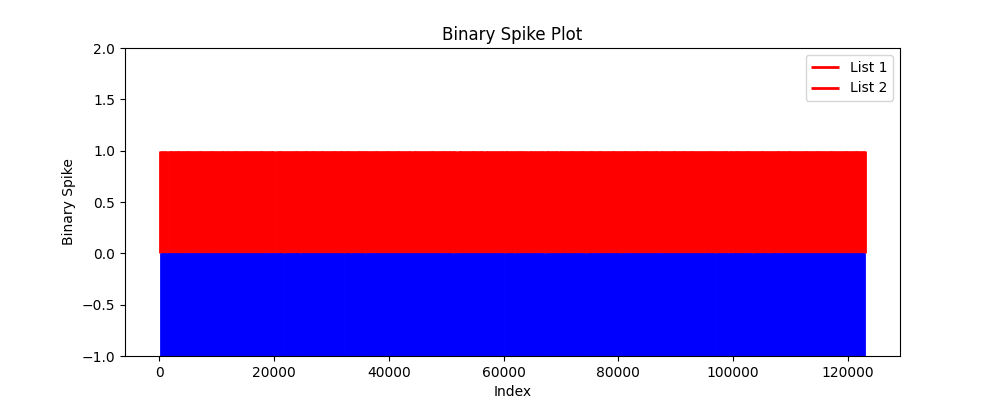

39
36


In [7]:
%matplotlib widget
import matplotlib.pyplot as plt

# Define the two lists of spike indices
list1 = MUPulsesA[6][0]
list2 = MUPulsesB[7]["SpikeTrain"]

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 4))

# Set the y-axis limits
ax.set_ylim(-1, 2)

# Plot the first list of spike indices
for i in list1:
    ax.vlines(i, 0, 1, colors='r', linewidth=2)

# Plot the second list of spike indices
for i in list2:
    ax.vlines(i, 0, -1, colors='b', linewidth=2)

# Add labels and title
ax.set_xlabel('Index')
ax.set_ylabel('Binary Spike')
ax.set_title('Binary Spike Plot')

# Add legend
ax.legend(['List 1', 'List 2'], loc='upper right')

# Display the plot
plt.show()
print(roa_matrix[7][6])
print(roa_matrix[5][1])

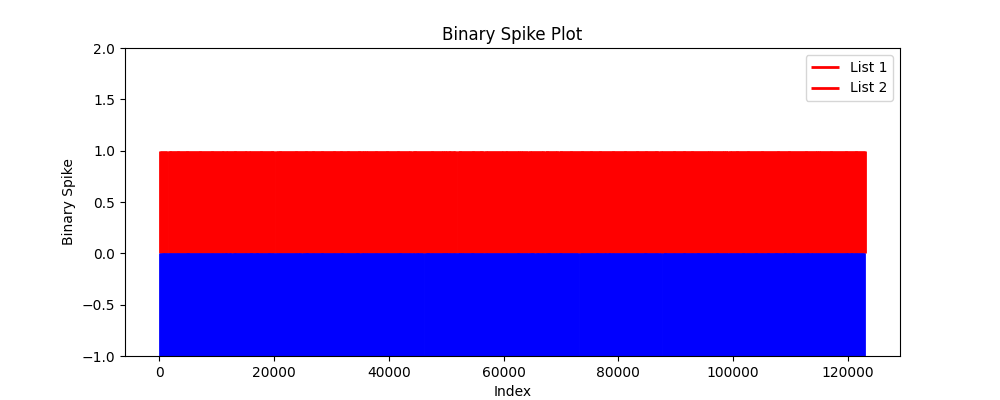

In [8]:
%matplotlib widget
import matplotlib.pyplot as plt

# Define the two lists of spike indices
list1 = MUPulsesA[6][0]
list2 = MUPulsesB[5]["SpikeTrain"]

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 4))

# Set the y-axis limits
ax.set_ylim(-1, 2)

# Plot the first list of spike indices
for i in list1:
    ax.vlines(i, 0, 1, colors='r', linewidth=2)

# Plot the second list of spike indices
for i in list2:
    ax.vlines(i, 0, -1, colors='b', linewidth=2)

# Add labels and title
ax.set_xlabel('Index')
ax.set_ylabel('Binary Spike')
ax.set_title('Binary Spike Plot')

# Add legend
ax.legend(['List 1', 'List 2'], loc='upper right')

# Display the plot
plt.show()

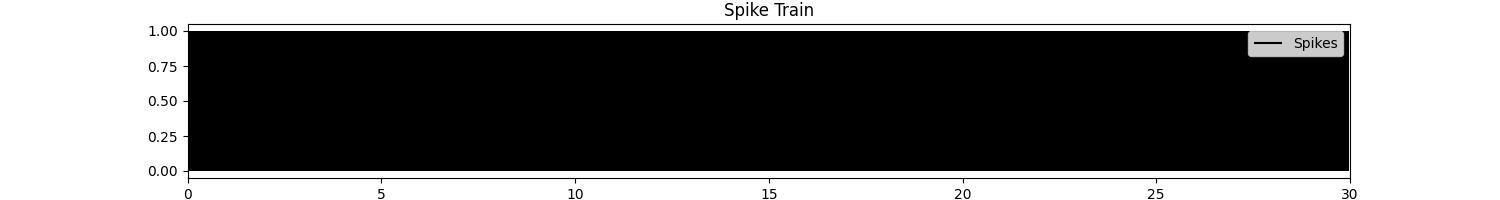

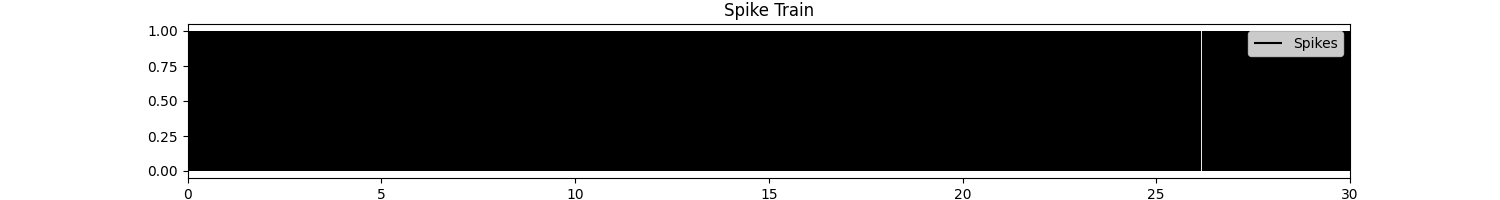

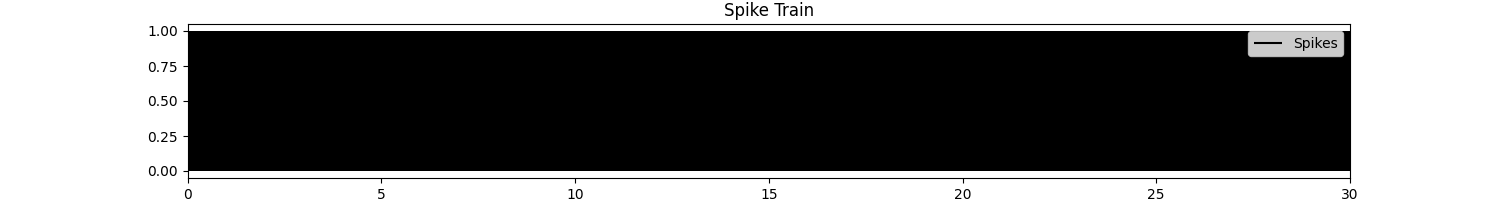

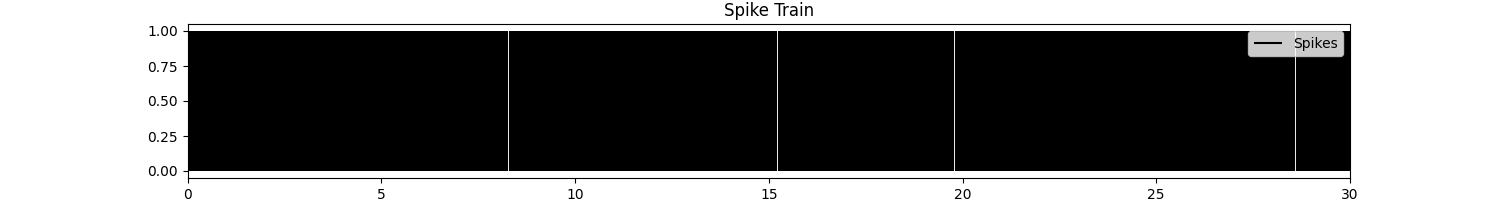

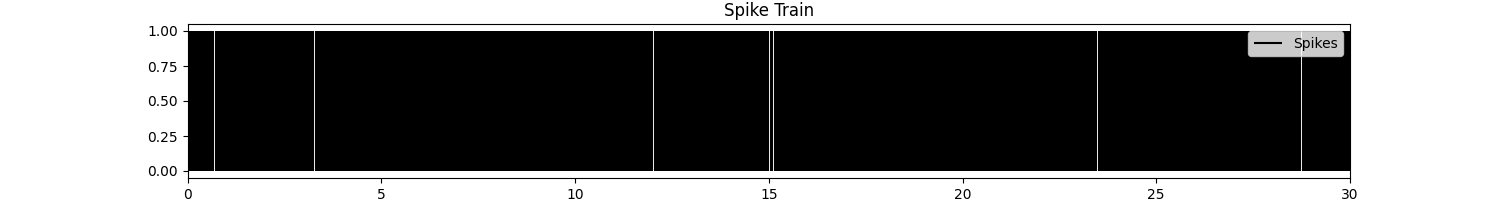

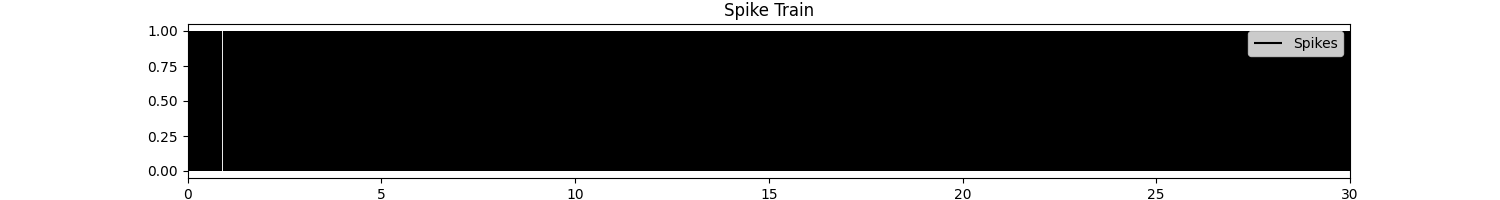

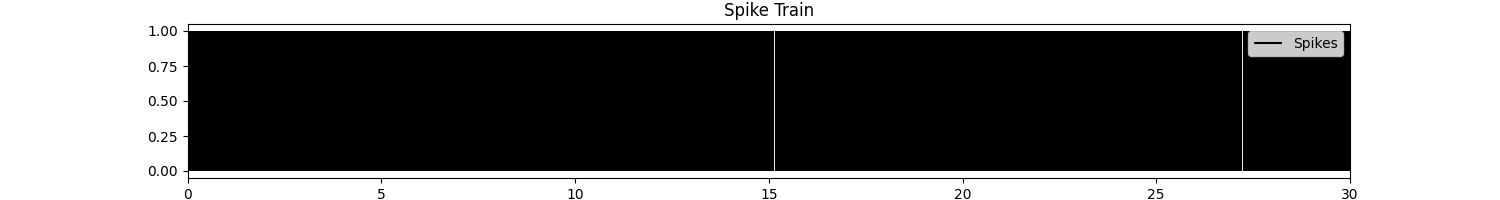

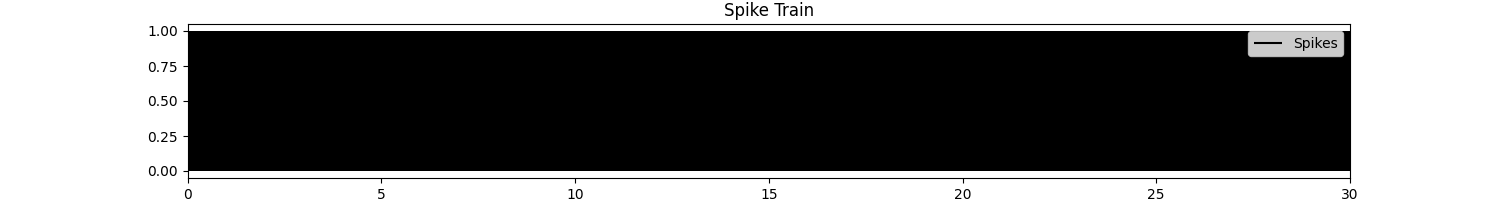

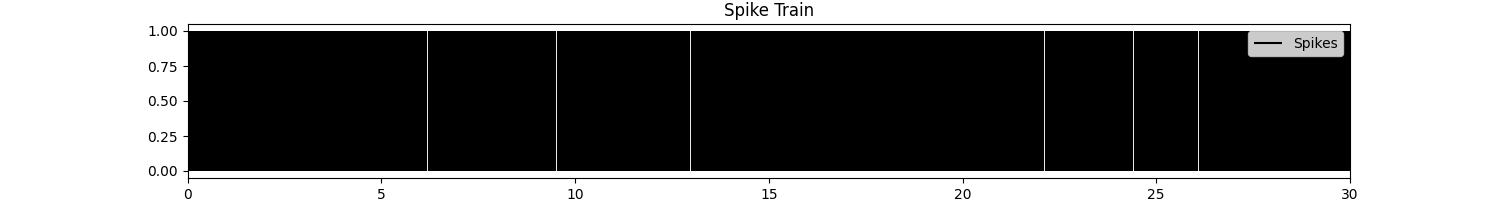

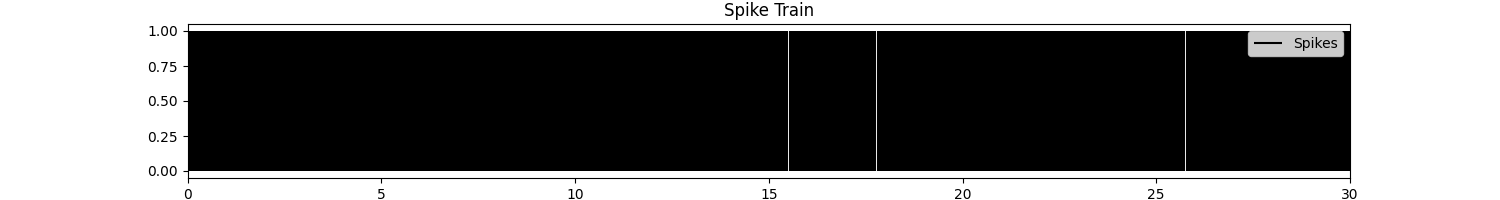

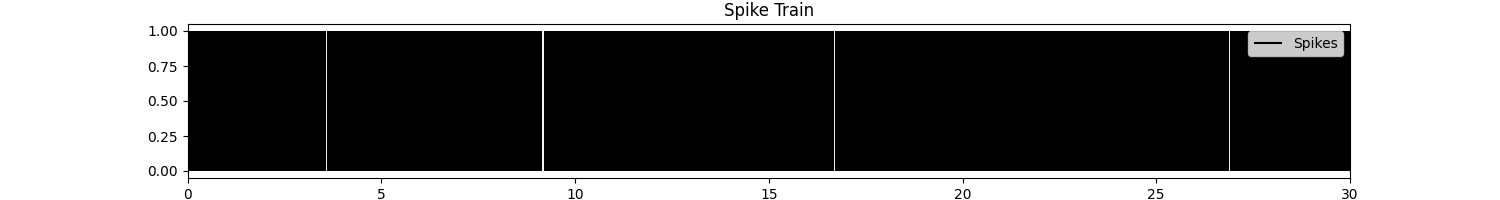

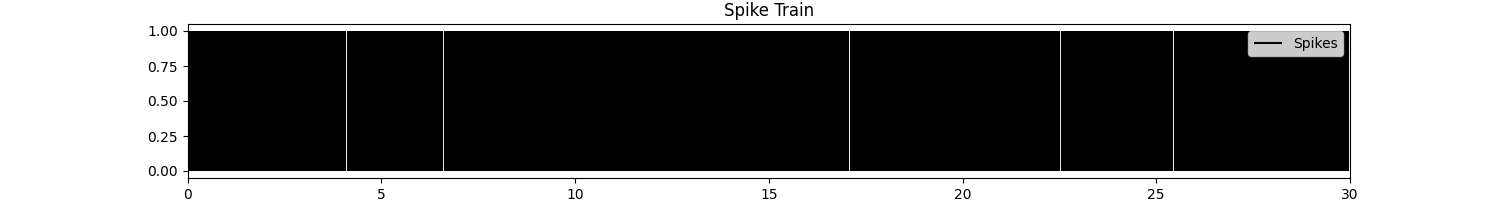

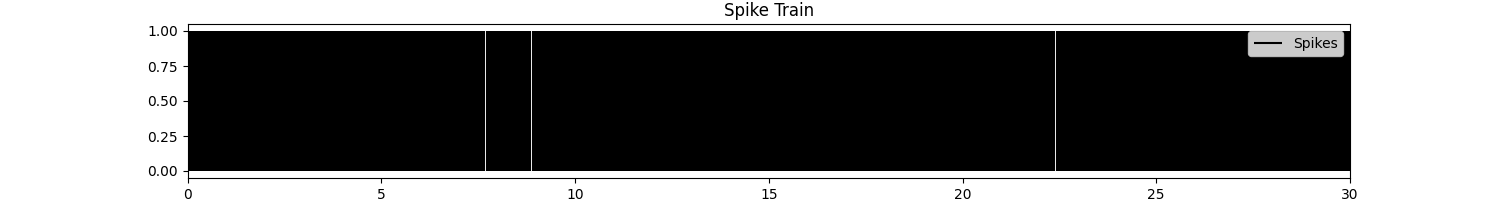

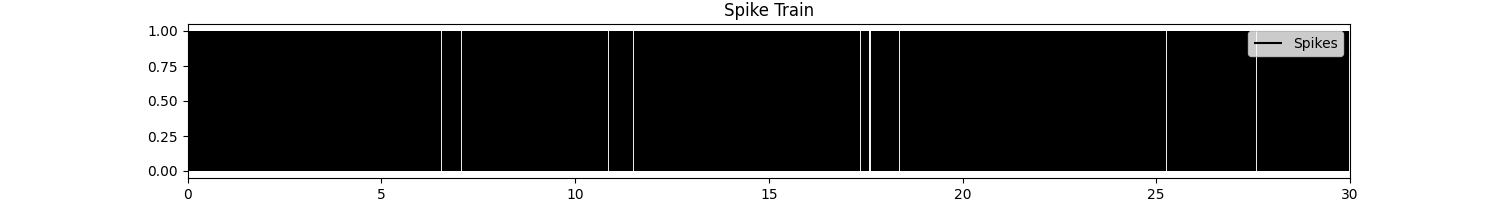

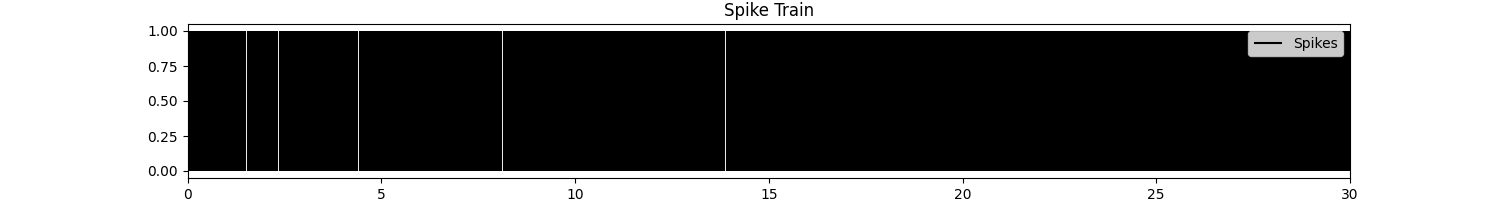

In [9]:
for list in MUPulsesB:
    plt.figure(figsize=(15, 2))
    time_interval_indices = np.divide(list["SpikeTrain"], 4096)
    plt.vlines(time_interval_indices, 0,1, color='black', linestyle='solid', label='Spikes')
    # Customize the plot as needed
    plt.xlim([0,30])
    plt.xlabel('Time in S')
    plt.title('Spike Train')
    plt.legend()
    plt.show()

In [10]:
print(np.divide(list2,2))

[   98.5   182.    283.    367.5   452.    530.    617.    689.    770.5
   866.    961.5  1051.   1140.5  1220.5  1297.   1382.5  1455.   1537.
  1624.   1708.   1781.   1905.   1973.   2050.   2123.5  2211.   2297.5
  2380.5  2473.5  2547.   2620.   2700.   2776.   2853.5  2947.5  3032.5
  3118.   3212.   3304.5  3378.   3471.   3554.5  3629.5  3734.5  3826.
  3898.5  3988.5  4063.   4136.5  4226.5  4311.5  4392.5  4468.   4568.
  4657.5  4741.   4825.5  4902.   4998.5  5092.5  5200.   5299.5  5390.5
  5468.   5540.   5616.5  5693.   5784.   5856.   5943.   6040.5  6112.
  6205.   6281.5  6378.   6469.5  6553.   6632.5  6707.   6788.5  6869.5
  6956.5  7031.   7117.   7204.5  7274.5  7364.   7459.5  7534.   7615.5
  7703.   7789.5  7874.5  7955.5  8034.5  8112.5  8188.5  8261.   8327.5
  8399.5  8478.5  8558.5  8641.5  8727.   8805.5  8875.   8954.   9044.
  9113.5  9209.5  9287.   9355.5  9442.5  9524.   9603.5  9684.   9760.
  9837.   9911.  10002.5 10087.  10173.5 10266.  10371.  

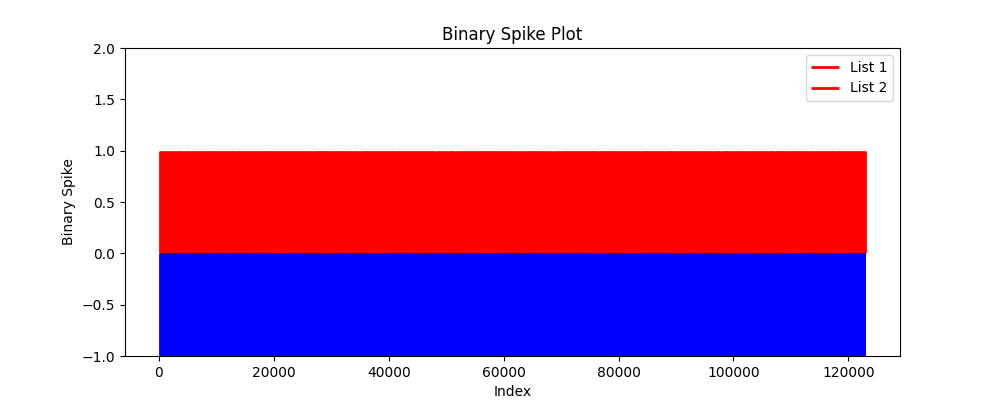

In [11]:
%matplotlib widget
import matplotlib.pyplot as plt

# Define the two lists of spike indices
list1 = MUPulsesA[30][0]
list2 = MUPulsesB[12]["SpikeTrain"]

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 4))

# Set the y-axis limits
ax.set_ylim(-1, 2)

# Plot the first list of spike indices
for i in list1:
    ax.vlines(i, 0, 1, colors='r', linewidth=2)

# Plot the second list of spike indices
for i in list2:
    ax.vlines(i, 0, -1, colors='b', linewidth=2)

# Add labels and title
ax.set_xlabel('Index')
ax.set_ylabel('Binary Spike')
ax.set_title('Binary Spike Plot')

# Add legend
ax.legend(['List 1', 'List 2'], loc='upper right')

# Display the plot
plt.show()

In [12]:
sns.heatmap(roa_matrix, cmap='coolwarm')

<Axes: title={'center': 'Binary Spike Plot'}>

In [13]:
sns.heatmap(dup_matrix, cmap='coolwarm')

<Axes: title={'center': 'Binary Spike Plot'}>